In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from loaders import *
from sklearn.manifold import TSNE
from rollout import *

/home/beans/bespoke/constants.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propref_aux_target['ixx'] = list(range(len(propref_aux_target))) # dumb self ix so can grab sigmoid from within this smaller df


In [2]:
%%time
model_stem = "1.18_avg"
SKIP_IX = 20

trn_rollout = load_object(f"{BESPOKE_ROOT}/tmp/trn_{model_stem}_rollout.pkl")

CPU times: user 0 ns, sys: 1.05 s, total: 1.05 s
Wall time: 1.06 s


In [3]:
%%time
# all rollouts should be already flattened and calculated
run_ids = ["run_555a", "run_556a", "run_556b", "run_556c"]
rw_rollouts = [load_object(f"{BESPOKE_ROOT}/tmp/{run_id}_{model_stem}_rollout.pkl") for run_id in run_ids]

CPU times: user 596 ms, sys: 10.3 s, total: 10.9 s
Wall time: 11.2 s


In [4]:
for r in rw_rollouts:
    skipify(r, 20)

In [5]:
rollouts = [trn_rollout] + rw_rollouts

In [6]:
# cat together

def combine_rollouts(rollouts, attr):
    return np.concatenate([getattr(r, attr) for r in rollouts])

images = combine_rollouts(rollouts, "img")
acts = combine_rollouts(rollouts, "final_acts")
aux = combine_rollouts(rollouts, "aux")
wps = combine_rollouts(rollouts, "wps")
wps_p = combine_rollouts(rollouts, "wps_p")
aux_targets_p = combine_rollouts(rollouts, "aux_targets_p")
obsnet_outs = combine_rollouts(rollouts, "obsnet_outs")

acts.shape, images.shape, aux.shape, wps.shape, wps_p.shape

((1615, 1792), (1615, 360, 1440, 4), (1615, 33), (1615, 150), (1615, 150))

In [7]:
from rollout import *
df = pd.concat([df_from_rollout(r) for r in rollouts])
df.shape

(1615, 44)

In [8]:
%%time
# dim reduce
def get_tsne(n_components):
    tsne = TSNE(
        random_state = 123,
        n_components=n_components,
        verbose=0,
        perplexity=40,
        method='exact' if n_components>4 else 'barnes_hut',
        n_iter=300) \
        .fit_transform(acts)
    return tsne
tsne = get_tsne(3)

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 28.4 s, sys: 46.5 ms, total: 28.5 s
Wall time: 1.2 s


In [9]:
"""df['tsne1'] = tsne[:, 0]
df['tsne2'] = tsne[:, 1]
df['tsne3'] = tsne[:, 2]

df.shape"""

"df['tsne1'] = tsne[:, 0]\ndf['tsne2'] = tsne[:, 1]\ndf['tsne3'] = tsne[:, 2]\n\ndf.shape"

In [10]:
df.to_pickle(f"{BESPOKE_ROOT}/tmp/dr_df.pkl")
np.save(f"{BESPOKE_ROOT}/tmp/dr_imgs.npy", images)
np.save(f"{BESPOKE_ROOT}/tmp/dr_acts.npy", acts)
np.save(f"{BESPOKE_ROOT}/tmp/dr_aux.npy", aux)
np.save(f"{BESPOKE_ROOT}/tmp/dr_wps.npy", wps)
np.save(f"{BESPOKE_ROOT}/tmp/dr_wps_p.npy", wps_p)
np.save(f"{BESPOKE_ROOT}/tmp/aux_targets_p.npy", aux_targets_p)
np.save(f"{BESPOKE_ROOT}/tmp/obsnet_outs.npy", obsnet_outs)

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


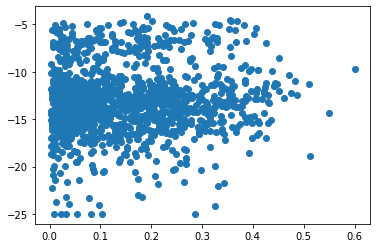

In [14]:
plt.scatter(df.traj_max_angle, np.clip(np.log(df.te), -25, 0))

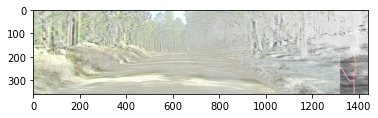

In [15]:
plt.imshow(images[-1])

In [16]:
df.shape

(1375, 19)

(array([ 36., 115., 146., 164., 105.,  57.,  18.,   8.,   3.,   3.]),
 array([-7.4492188, -6.9859376, -6.5226564, -6.059375 , -5.5960937,
        -5.1328125, -4.6695313, -4.20625  , -3.7429688, -3.2796874,
        -2.8164062], dtype=float32),
 <BarContainer object of 10 artists>)

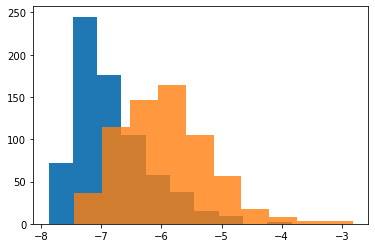

In [17]:
plt.hist(df[df.is_rw==0]['unc_p'])
plt.hist(df[df.is_rw==1]['unc_p'], alpha=.8)

(array([ 4338782.,  1538666.,  3522693.,  3763298.,  5542107.,  6694662.,
         7833071.,  8334388., 10324019., 11258113., 11900454., 11319937.,
        11254995., 10187246.,  8143464.,  5836271.,  4986404.,  3540238.,
         2798675.,  3740117.]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <BarContainer object of 20 artists>)

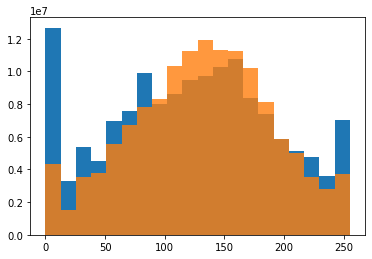

In [18]:
plt.hist(trn_img[::10].flatten(), bins=20)
plt.hist(rw_img[::10].flatten(), alpha=.8, bins=20)

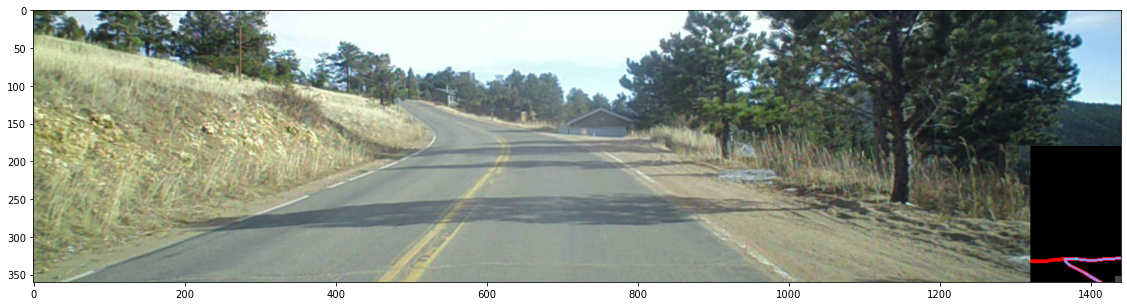

In [20]:
_img = rw_img[0][:,:,:3]
plt.figure(figsize=(20,5))
plt.imshow(_img)